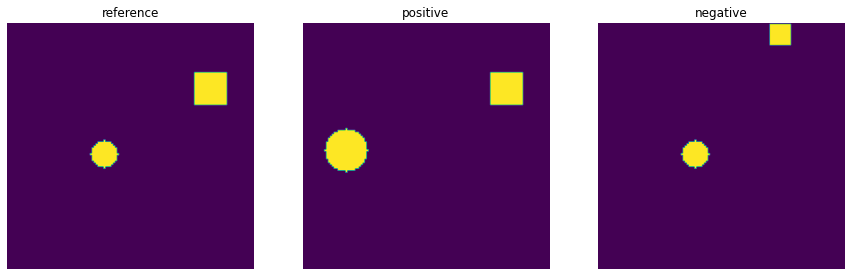

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
# Create an example dataset of squares and circles at random locations and overlapping

def generate_image_pair():
    height, width, channels = 128, 128, 1
    color = (1, 1, 1)

    # get a template
    reference_img = np.zeros((height, width, channels), np.uint8)
    square_size = 10 + np.random.randint(int(width / 8))
    square_location = (np.random.randint(height - square_size), 
                       np.random.randint(width - square_size))
    circle_radius = 5 + np.random.randint(int(width / 8))
    circle_location = (circle_radius + np.random.randint(width - 2 * circle_radius), 
                       circle_radius + np.random.randint(height - 2 * circle_radius))
    cv.circle(reference_img, circle_location, circle_radius, color, -1)
    cv.rectangle(reference_img,
                 square_location, 
                 (square_location[0] + square_size, square_location[1] + square_size), color, -1)

    # create a positive pair: same shape and location of square, different for circle
    positive_img = np.zeros((height, width, channels), np.uint8)
    second_circle_radius = 5 + np.random.randint(int(width / 8))
    second_circle_location = (second_circle_radius + np.random.randint(width - 2 * second_circle_radius), 
                       second_circle_radius + np.random.randint(height - 2 * second_circle_radius))
    cv.circle(positive_img, second_circle_location, second_circle_radius, color, -1)
    cv.rectangle(positive_img,
                    square_location, 
                    (square_location[0] + square_size, square_location[1] + square_size), color, -1)

    # create a negative pair: same shape and location of circle, different for square
    negative_img = np.zeros((height, width, channels), np.uint8)
    second_square_size = 10 + np.random.randint(int(width / 8))
    second_square_location = (np.random.randint(height - square_size), 
                       np.random.randint(width - square_size))
    cv.circle(negative_img, circle_location, circle_radius, color, -1)
    cv.rectangle(negative_img,
                 second_square_location, 
                 (second_square_location[0] + second_square_size, second_square_location[1] + second_square_size), color, -1)
    return reference_img, positive_img, negative_img

r, p, n = generate_image_pair()
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(r)
ax[0].set_title('reference')
ax[0].axis('off')
ax[1].imshow(p)
ax[1].set_title('positive')
ax[1].axis('off')
ax[2].imshow(n)
ax[2].set_title('negative')
ax[2].axis('off')
plt.show()

In [4]:
# Define pytorch data set and data loader
from typing import Dict
import torch
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader as TorchDataLoader

# create a pytorch dataset
class Dataset(TorchDataset):

    def __len__(self) -> int:
        return 1000

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        reference, positive, negative = generate_image_pair()
        result = {'reference': torch.from_numpy(reference).permute(2, 0, 1).float(),
                  'positive': torch.from_numpy(positive).permute(2, 0, 1).float(),
                  'negative': torch.from_numpy(negative).permute(2, 0, 1).float()}
        return result

dataset = Dataset()
torch_dataloader = TorchDataLoader(
    dataset=dataset,
    batch_size=100,
    shuffle=True,
)
for batch_idx, data in enumerate(torch_dataloader):
    print(f'{batch_idx}: {data["reference"].size()}')
    break

0: torch.Size([100, 1, 128, 128])
1: torch.Size([100, 1, 128, 128])
2: torch.Size([100, 1, 128, 128])
3: torch.Size([100, 1, 128, 128])
4: torch.Size([100, 1, 128, 128])
5: torch.Size([100, 1, 128, 128])
6: torch.Size([100, 1, 128, 128])
7: torch.Size([100, 1, 128, 128])
8: torch.Size([100, 1, 128, 128])
9: torch.Size([100, 1, 128, 128])


In [5]:
# Define encoder g()
from torch import nn
from typing import OrderedDict

class Encoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(1, 8, 3, stride=2)),
          ('bn_1', torch.nn.BatchNorm2d(8)),
          ('relu1', nn.ReLU()),
          ('conv2', nn.Conv2d(8, 16, 3, stride=2)),
          ('bn_2', torch.nn.BatchNorm2d(16)),
          ('relu2', nn.ReLU()),
          ('conv3', nn.Conv2d(16, 32, 3, stride=2)),
          ('bn_3', torch.nn.BatchNorm2d(32)),
          ('relu3', nn.ReLU()),
          ('conv4', nn.Conv2d(32, 64, 3, stride=2)),
          ('bn_4', torch.nn.BatchNorm2d(64)),
          ('relu4', nn.ReLU()),
          ('conv5', nn.Conv2d(64, 128, 3, stride=2)),
          ('bn_5', torch.nn.BatchNorm2d(128)),
          ('relu5', nn.ReLU()),
          ('conv6', nn.Conv2d(128, 256, 3, stride=2)),
        ]))

    def forward(self, input: torch.Tensor):
        return self.layers(input).squeeze(-1).squeeze(-1)


encoder = Encoder()
encoder(torch.zeros((1, 1, 128, 128))).size()

torch.Size([1, 256])

In [65]:
# Update encoder to contain res blocks
from typing import Tuple


class ResEncoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(1, 8, 3, stride=2)),
          ('bn_1', torch.nn.BatchNorm2d(8)),
          ('relu1', nn.ReLU()),
          ('res2', ResidualBlock(8, 16, padding=(1, 1), strides=(2, 1))),
          ('res3', ResidualBlock(16, 32, padding=(1, 1), strides=(2, 1))),
          ('res4', ResidualBlock(32, 64, padding=(1, 1), strides=(2, 1))),
          ('res5', ResidualBlock(64, 128, padding=(1, 1), strides=(2, 1))),
          ('res6', ResidualBlock(128, 256, padding=(1, 1), strides=(2, 1))),
          ('pool', nn.MaxPool2d(2))
        ]))
        self.fc = nn.Linear(256, 5)

    def forward(self, input: torch.Tensor):
        high_dim_feature = self.layers(input).squeeze(-1).squeeze(-1)
        return self.fc(high_dim_feature)


class ResidualBlock(torch.nn.Module):

    def __init__(self, input_channels,
                 output_channels,
                 batch_norm: bool = True,
                 activation: torch.nn.ReLU = torch.nn.ReLU(),
                 strides: Tuple[int, int] = (1, 1),
                 padding: Tuple[int, int] = (0, 0),
                 kernel_sizes: Tuple[int, int] = (3, 3)):
        """
        Create a residual block
        :param input_channels: number of input channels at input
        :param output_channels: number of input channels at input
        :param batch_norm: bool specifying to use batch norm 2d (True)
        :param activation: specify torch nn module activation (ReLU)
        :param pool: specify pooling layer applied as first layer
        :param strides: tuple specifying the stride and so the down sampling
        """
        super().__init__()
        self._down_sample =  torch.nn.Conv2d(in_channels=input_channels,
                                             out_channels=output_channels,
                                             kernel_size=1,
                                             stride=strides[0],
                                             bias=False)
        self._final_activation = activation
        elements = []
        elements.append(('conv_0', torch.nn.Conv2d(in_channels=input_channels,
                                                   out_channels=output_channels,
                                                   kernel_size=kernel_sizes[0],
                                                   padding=padding[0],
                                                   stride=strides[0],
                                                   bias=False)))
        if batch_norm:
            elements.append(('bn_0', torch.nn.BatchNorm2d(output_channels)))
        elements.append(('act_0', activation))
        elements.append(('conv_1', torch.nn.Conv2d(in_channels=output_channels,
                                                   out_channels=output_channels,
                                                   kernel_size=kernel_sizes[1],
                                                   padding=padding[1],
                                                   stride=strides[1],
                                                   bias=False)))
        if batch_norm:
            elements.append(('bn_1', torch.nn.BatchNorm2d(output_channels)))
        elements.append(('act_1', activation))
        self.residual_net = torch.nn.Sequential(OrderedDict(elements))

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        x = self.residual_net(inputs)
        x += self._down_sample(inputs)
        return self._final_activation(x)

encoder = ResEncoder()
encoder(torch.zeros((1, 1, 128, 128))).size()

torch.Size([1, 5])

In [66]:
import torch.nn.functional as F
# Define triplet loss
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    Source: https://github.com/adambielski/siamese-triplet/blob/master/losses.py
    """

    def __init__(self, margin = 10):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        #print(f'pos dis: {distance_positive}, neg dis: {distance_negative}')
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()


triplet_loss = TripletLoss()
for batch_idx, data in enumerate(torch_dataloader):
    anchor = encoder(data['reference'])
    positive = encoder(data['positive'])
    negative = encoder(data['negative'])
    loss = triplet_loss(anchor, positive, negative)
    print(loss)
    break


tensor(50.0352, grad_fn=<MeanBackward0>)


In [67]:
from datetime import datetime

def get_date_time_tag() -> str:
    return str(datetime.strftime(datetime.now(), format="%y-%m-%d_%H-%M-%S"))

get_date_time_tag()

'21-04-20_09-40-58'

In [68]:
# Train encoder
for p in encoder.parameters():
    p.requires_grad = True
encoder.train()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01, weight_decay=0.0001)
for epoch in range(20):
    losses = []
    for batch_idx, data in enumerate(torch_dataloader):
        optimizer.zero_grad()
        anchor = encoder(data['reference'])
        positive = encoder(data['positive'])
        negative = encoder(data['negative'])
        loss = triplet_loss(anchor, positive, negative)
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().detach().item())
    print(f'{get_date_time_tag()}: epoch {epoch} - loss {np.mean(losses): 0.3f} [{np.std(losses): 0.2f}]')

21-04-20_09-41-19: epoch 0 - loss  46.997 [ 4.91]
21-04-20_09-41-36: epoch 1 - loss  27.408 [ 10.17]
21-04-20_09-41-53: epoch 2 - loss  19.438 [ 6.25]
21-04-20_09-42-08: epoch 3 - loss  12.182 [ 5.01]
21-04-20_09-42-25: epoch 4 - loss  6.331 [ 1.50]
21-04-20_09-42-42: epoch 5 - loss  9.241 [ 8.10]
21-04-20_09-43-00: epoch 6 - loss  7.677 [ 2.93]
21-04-20_09-43-16: epoch 7 - loss  5.876 [ 4.37]
21-04-20_09-43-34: epoch 8 - loss  5.029 [ 2.61]
21-04-20_09-43-49: epoch 9 - loss  2.851 [ 1.56]
21-04-20_09-44-05: epoch 10 - loss  6.631 [ 4.52]
21-04-20_09-44-20: epoch 11 - loss  5.883 [ 3.42]
21-04-20_09-44-36: epoch 12 - loss  3.454 [ 1.71]
21-04-20_09-44-52: epoch 13 - loss  2.356 [ 1.37]
21-04-20_09-45-08: epoch 14 - loss  3.355 [ 2.47]
21-04-20_09-45-23: epoch 15 - loss  5.010 [ 2.17]
21-04-20_09-45-39: epoch 16 - loss  2.480 [ 1.51]
21-04-20_09-45-55: epoch 17 - loss  2.510 [ 1.28]
21-04-20_09-46-10: epoch 18 - loss  2.925 [ 3.42]
21-04-20_09-46-26: epoch 19 - loss  3.305 [ 1.14]


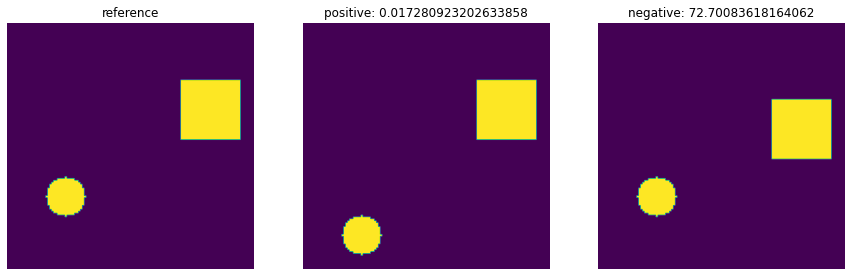

In [69]:
# play with anchor and positive / negative samples
height, width, channels = 128, 128, 1
color = (1, 1, 1)

reference_img = np.zeros((height, width, channels), np.uint8)
square_size = 30
square_location = (90, 30)
circle_radius = 10
circle_location = (30, 90)
cv.circle(reference_img, circle_location, circle_radius, color, -1)
cv.rectangle(reference_img, square_location, 
             (square_location[0] + square_size, square_location[1] + square_size), color, -1)
positive_img = np.zeros((height, width, channels), np.uint8)
second_circle_location = (30, 110) # move 20 down
cv.circle(positive_img, second_circle_location, circle_radius, color, -1)
cv.rectangle(positive_img,
             square_location, 
             (square_location[0] + square_size, square_location[1] + square_size), color, -1)
negative_img = np.zeros((height, width, channels), np.uint8)
second_square_location = (90, 40) # move 10 down
cv.circle(negative_img, circle_location, circle_radius, color, -1)
cv.rectangle(negative_img,
             second_square_location, 
             (second_square_location[0] + square_size, second_square_location[1] + square_size), color, -1)

r = encoder(torch.from_numpy(reference_img).permute(2, 0, 1).float().unsqueeze(0))
p = encoder(torch.from_numpy(positive_img).permute(2, 0, 1).float().unsqueeze(0))
n = encoder(torch.from_numpy(negative_img).permute(2, 0, 1).float().unsqueeze(0))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(reference_img)
ax[0].axis('off')
ax[0].set_title('reference')
ax[1].imshow(positive_img)
ax[1].axis('off')
ax[1].set_title(f'positive: {((r - p).pow(2).sum(1)).cpu().detach().item()}')
ax[2].imshow(negative_img)
ax[2].axis('off')
ax[2].set_title(f'negative: {((r - n).pow(2).sum(1)).cpu().detach().item()}')
plt.show()



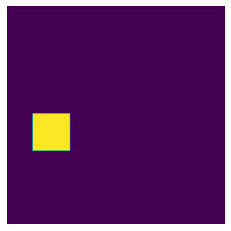

In [15]:
# Second question: is all information for generating image of square in latent representation?

def generate_random_square():
    img = np.zeros((height, width, channels), np.uint8)
    square_size = 10 + np.random.randint(int(width / 8))
    square_location = (np.random.randint(height - square_size), 
                        np.random.randint(width - square_size))
    cv.rectangle(img,
                 square_location, 
                 (square_location[0] + square_size, square_location[1] + square_size), color, -1)
    return img
plt.clf()
plt.imshow(generate_random_square())
plt.axis('off')
plt.show()

In [16]:
class SquareDataset(TorchDataset):

    def __len__(self) -> int:
        return 1000

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        return torch.from_numpy(generate_random_square()).permute(2, 0, 1).float()

square_dataloader = TorchDataLoader(
    dataset=SquareDataset(),
    batch_size=100,
    shuffle=True,
)
for batch_idx, data in enumerate(square_dataloader):
    print(f'{batch_idx}: {data.size()}')
    break

0: torch.Size([100, 1, 128, 128])


In [105]:
# Define encoder g()
class Decoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(OrderedDict([
            ('deconv1', nn.ConvTranspose2d(5, 128, 3, stride=2)),
            ('relu1', nn.ReLU()),
            ('deconv2', nn.ConvTranspose2d(128, 64, 3, stride=2)),
            ('relu2', nn.ReLU()),
            ('deconv3', nn.ConvTranspose2d(64, 32, 3, stride=2)),
            ('relu3', nn.ReLU()),
            ('deconv4', nn.ConvTranspose2d(32, 16, 3, stride=2)),
            ('relu4', nn.ReLU()),
            ('deconv5', nn.ConvTranspose2d(16, 8, 3, stride=2)),
            ('relu5', nn.ReLU()),
            ('deconv6', nn.ConvTranspose2d(8, 1, 4, stride=2)),
        ]))

    def forward(self, inpt: torch.Tensor):
        logits = self.layers(inpt.unsqueeze(-1).unsqueeze(-1))
        return torch.sigmoid(logits)


decoder = Decoder()
decoder(torch.zeros((1, 5))).size()

torch.Size([1, 1, 128, 128])

In [106]:
# Train decoder
# avoid encoder being trained
for p in encoder.parameters():
    p.requires_grad = False
encoder.eval()
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.01, weight_decay=0.0001)
bce_loss = nn.BCELoss()
for epoch in range(10):
    losses = []
    for batch_idx, data in enumerate(square_dataloader):
        dec_optimizer.zero_grad()
        loss = bce_loss(decoder(encoder(data)), data)
        loss.backward()
        dec_optimizer.step()
        losses.append(loss.cpu().detach().item())
    print(f'{get_date_time_tag()}: epoch {epoch} - loss {np.mean(losses): 0.3f} [{np.std(losses): 0.2f}]')

21-04-20_10-53-19: epoch 0 - loss  0.388 [ 0.21]
21-04-20_10-53-23: epoch 1 - loss  0.093 [ 0.02]
21-04-20_10-53-29: epoch 2 - loss  0.062 [ 0.01]
21-04-20_10-53-37: epoch 3 - loss  0.052 [ 0.00]
21-04-20_10-53-45: epoch 4 - loss  0.047 [ 0.00]
21-04-20_10-53-51: epoch 5 - loss  0.044 [ 0.00]
21-04-20_10-53-59: epoch 6 - loss  0.043 [ 0.00]
21-04-20_10-54-05: epoch 7 - loss  0.043 [ 0.00]
21-04-20_10-54-12: epoch 8 - loss  0.042 [ 0.00]
21-04-20_10-54-17: epoch 9 - loss  0.044 [ 0.00]


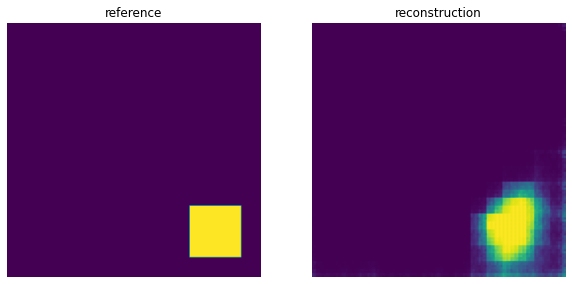

In [73]:
# qualitatively check performance of decoder
reference = generate_random_square()
reconstruction = decoder(encoder(torch.from_numpy(reference).permute(2, 0, 1).float().unsqueeze(0))).cpu().detach().squeeze().numpy()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(reference)
ax[0].axis('off')
ax[0].set_title('reference')
ax[1].imshow(reconstruction)
ax[1].axis('off')
ax[1].set_title('reconstruction')
plt.show()

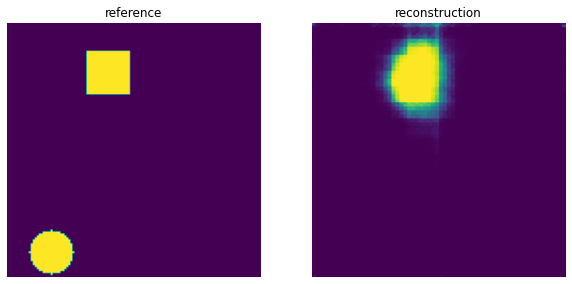

In [111]:
# qualitatively check with confusing circle
# qualitatively check performance of decoder
r, p, n = generate_image_pair()
reconstruction = decoder(encoder(torch.from_numpy(r).permute(2, 0, 1).float().unsqueeze(0))).cpu().detach().squeeze().numpy()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(r)
ax[0].axis('off')
ax[0].set_title('reference')
ax[1].imshow(reconstruction)
ax[1].axis('off')
ax[1].set_title('reconstruction')
plt.show()

## Define and train auto encoder for square to compare

In [81]:
# Define autoencoder

class AutoEncoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = ResEncoder()
        self.decoder = Decoder()

    def forward(self, input):
        feature = self.encoder(input)
        return self.decoder(feature)

autoencoder = AutoEncoder()
autoencoder(torch.zeros((1, 1, 128, 128))).size()

torch.Size([1, 1, 128, 128])

In [87]:
import copy
# Define dataset producing circle-square input images and square-only target images

class AutoencoderDataset(TorchDataset):

    def __len__(self) -> int:
        return 1000

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
    
        target_img = generate_random_square()
        # copy target image with square to create input image
        input_img = copy.deepcopy(target_img)
        # Add random circle 
        height, width, channels = 128, 128, 1
        color = (1, 1, 1)
        circle_radius = 5 + np.random.randint(int(width / 8))
        circle_location = (circle_radius + np.random.randint(width - 2 * circle_radius), 
                           circle_radius + np.random.randint(height - 2 * circle_radius))
        cv.circle(input_img, circle_location, circle_radius, color, -1)
    
        result = {'input': torch.from_numpy(input_img).permute(2, 0, 1).float(),
                  'target': torch.from_numpy(target_img).permute(2, 0, 1).float()}
        return result

ae_dataloader = TorchDataLoader(
    dataset=AutoencoderDataset(),
    batch_size=100,
    shuffle=True,
)
for batch_idx, data in enumerate(ae_dataloader):
    print(f'{batch_idx}: {data["input"].size()}')
    break

0: torch.Size([100, 1, 128, 128])


0: torch.Size([100, 1, 128, 128])


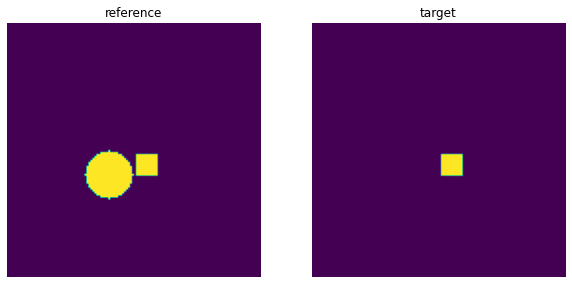

In [94]:
for batch_idx, data in enumerate(ae_dataloader):
    print(f'{batch_idx}: {data["input"].size()}')
    break
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(data['input'][0].squeeze().numpy())
ax[0].axis('off')
ax[0].set_title('reference')
ax[1].imshow(data['target'][0].squeeze().numpy())
ax[1].axis('off')
ax[1].set_title('target')
plt.show()

In [100]:
# Train autoencoder 
ae_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.01, weight_decay=0.0001)
bce_loss = nn.BCELoss()
for epoch in range(20):
    losses = []
    for batch_idx, data in enumerate(ae_dataloader):
        ae_optimizer.zero_grad()
        reconstruction = autoencoder(data['input'])
        loss = bce_loss(reconstruction, data['target'])
        loss.backward()
        ae_optimizer.step()
        losses.append(loss.cpu().detach().item())
    print(f'{get_date_time_tag()}: epoch {epoch} - loss {np.mean(losses): 0.3f} [{np.std(losses): 0.2f}]')

21-04-20_10-41-39: epoch 0 - loss  0.108 [ 0.09]
21-04-20_10-41-49: epoch 1 - loss  0.057 [ 0.01]
21-04-20_10-41-58: epoch 2 - loss  0.047 [ 0.00]
21-04-20_10-42-09: epoch 3 - loss  0.043 [ 0.00]
21-04-20_10-42-18: epoch 4 - loss  0.041 [ 0.00]
21-04-20_10-42-27: epoch 5 - loss  0.039 [ 0.00]
21-04-20_10-42-35: epoch 6 - loss  0.040 [ 0.00]
21-04-20_10-42-43: epoch 7 - loss  0.038 [ 0.00]
21-04-20_10-42-51: epoch 8 - loss  0.038 [ 0.00]
21-04-20_10-43-00: epoch 9 - loss  0.037 [ 0.00]
21-04-20_10-43-08: epoch 10 - loss  0.041 [ 0.00]
21-04-20_10-43-16: epoch 11 - loss  0.034 [ 0.00]
21-04-20_10-43-24: epoch 12 - loss  0.037 [ 0.00]
21-04-20_10-43-31: epoch 13 - loss  0.038 [ 0.00]
21-04-20_10-43-39: epoch 14 - loss  0.035 [ 0.00]
21-04-20_10-43-46: epoch 15 - loss  0.034 [ 0.00]
21-04-20_10-43-54: epoch 16 - loss  0.035 [ 0.00]
21-04-20_10-44-02: epoch 17 - loss  0.032 [ 0.00]
21-04-20_10-44-10: epoch 18 - loss  0.030 [ 0.00]
21-04-20_10-44-17: epoch 19 - loss  0.031 [ 0.00]


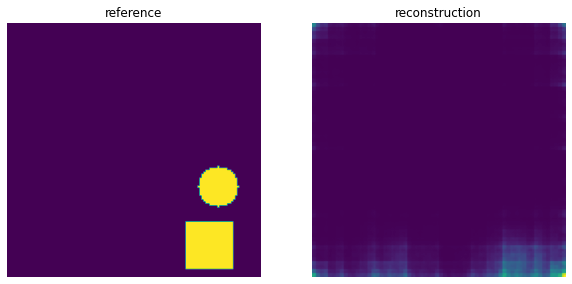

In [101]:
# qualitative evaluation
r, p, n = generate_image_pair()
reconstruction = autoencoder(torch.from_numpy(r).permute(2, 0, 1).float().unsqueeze(0)).cpu().detach().squeeze().numpy()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(r)
ax[0].axis('off')
ax[0].set_title('reference')
ax[1].imshow(reconstruction)
ax[1].axis('off')
ax[1].set_title('reconstruction')
plt.show()


## Compare both models on out-of-domain data

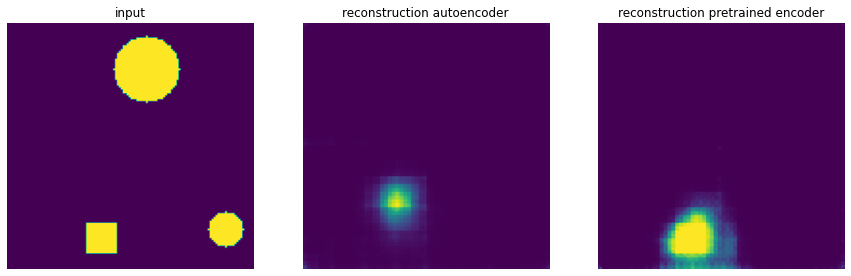

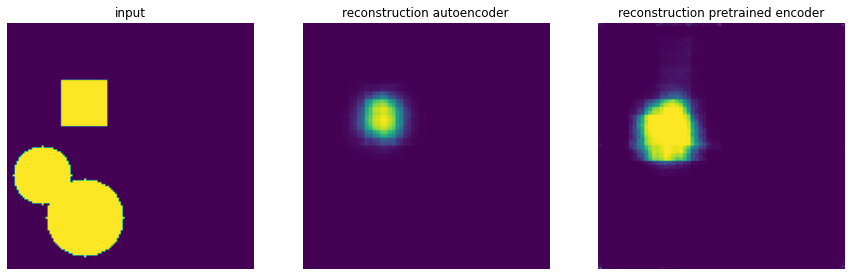

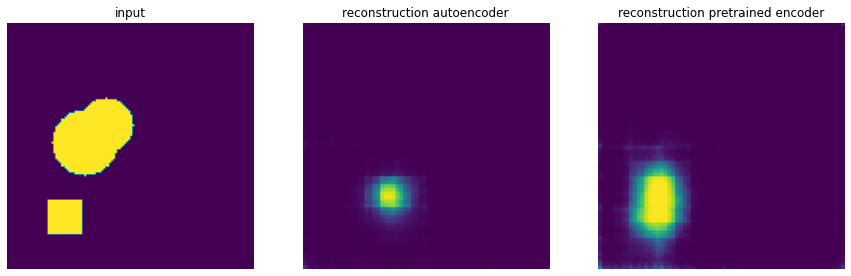

In [114]:
# Compare on images with more circles

def get_image_with_circles(n: int = 2):
    height, width, channels = 128, 128, 1
    color = (1, 1, 1)
    img = generate_random_square()
    for _ in range(n):
        # Add random circle 
        circle_radius = 5 + np.random.randint(int(width / 8))
        circle_location = (circle_radius + np.random.randint(width - 2 * circle_radius), 
                        circle_radius + np.random.randint(height - 2 * circle_radius))
        cv.circle(img, circle_location, circle_radius, color, -1)
    return img

for n in range(3):
    image = get_image_with_circles(2)
    tensor = torch.from_numpy(image).permute(2, 0, 1).float().unsqueeze(0)
    reconstruction_ae = autoencoder(tensor).cpu().detach().squeeze().numpy()
    reconstruction_triplet = decoder(encoder(tensor)).cpu().detach().squeeze().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title('input')
    ax[1].imshow(reconstruction_ae)
    ax[1].axis('off')
    ax[1].set_title('reconstruction autoencoder')
    ax[2].imshow(reconstruction_triplet)
    ax[2].axis('off')
    ax[2].set_title('reconstruction pretrained encoder')
    plt.show()


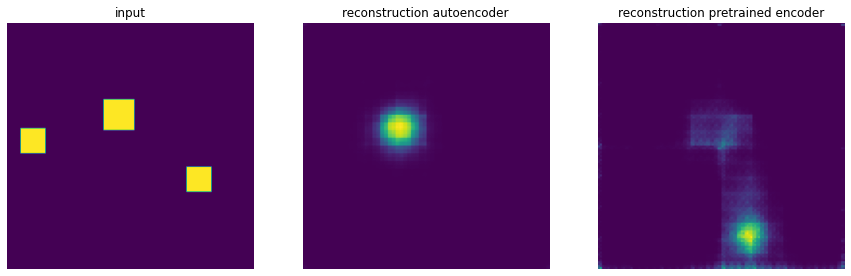

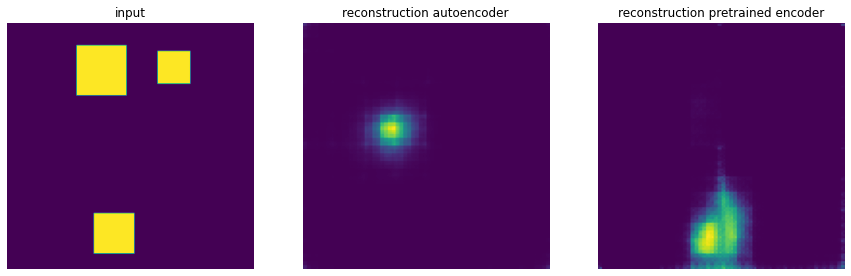

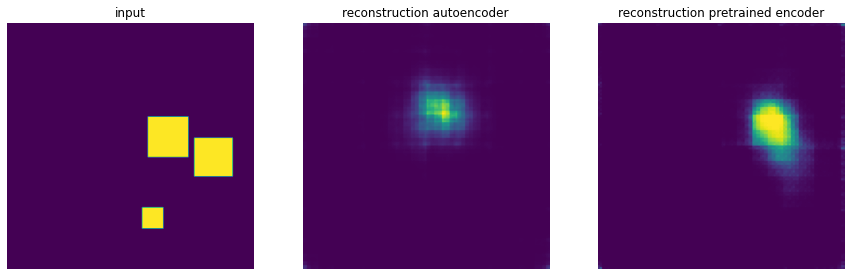

In [116]:
# Compare on images with more circles

def get_image_with_squares(n: int = 2):
    height, width, channels = 128, 128, 1
    color = (1, 1, 1)
    img = generate_random_square()
    for _ in range(n):
        # Add random circle 
        square_size = 10 + np.random.randint(int(width / 8))
        square_location = (np.random.randint(height - square_size), 
                            np.random.randint(width - square_size))
        cv.rectangle(img,
                    square_location, 
                    (square_location[0] + square_size, square_location[1] + square_size), color, -1)
    return img

for n in range(3):
    image = get_image_with_squares(2)
    tensor = torch.from_numpy(image).permute(2, 0, 1).float().unsqueeze(0)
    reconstruction_ae = autoencoder(tensor).cpu().detach().squeeze().numpy()
    reconstruction_triplet = decoder(encoder(tensor)).cpu().detach().squeeze().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title('input')
    ax[1].imshow(reconstruction_ae)
    ax[1].axis('off')
    ax[1].set_title('reconstruction autoencoder')
    ax[2].imshow(reconstruction_triplet)
    ax[2].axis('off')
    ax[2].set_title('reconstruction pretrained encoder')
    plt.show()

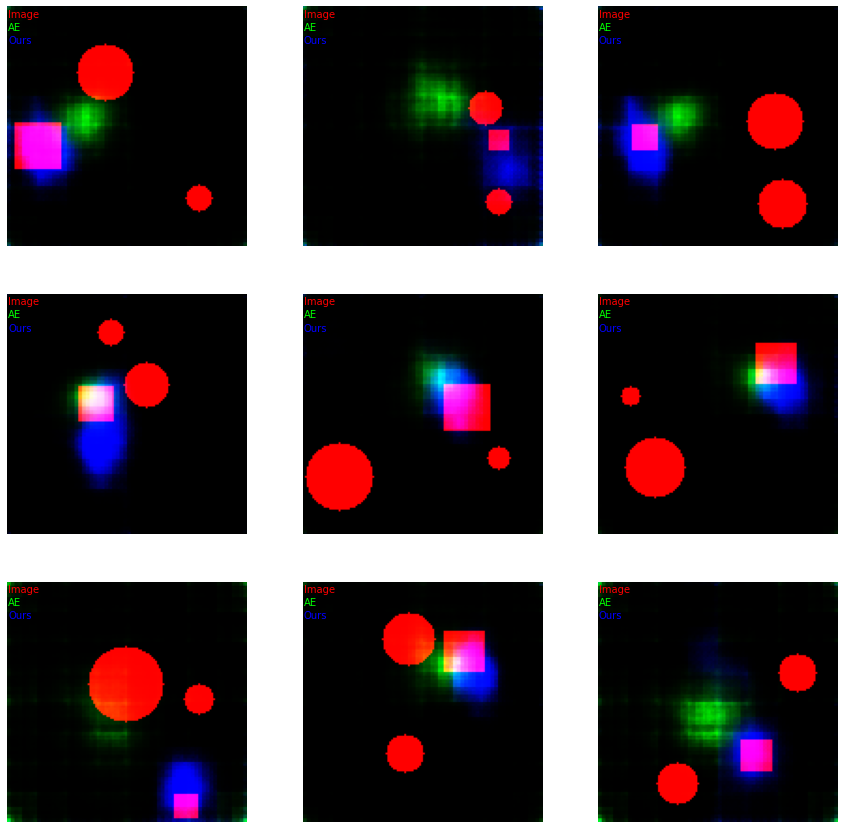

In [132]:
# Combine images over color values
def normalize(d: np.ndarray):
    d_min = np.amin(d)
    d_max = np.amax(d)
    return (d-d_min)/(d_max)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        image = get_image_with_circles(2)
        tensor = torch.from_numpy(image).permute(2, 0, 1).float().unsqueeze(0)
        reconstruction_ae = autoencoder(tensor).cpu().detach().squeeze().numpy()
        reconstruction_triplet = decoder(encoder(tensor)).cpu().detach().squeeze().numpy()

        stacked = np.stack([image.squeeze(), normalize(reconstruction_ae.squeeze()), normalize(reconstruction_triplet.squeeze())], axis=-1)
        axes[i, j].imshow(stacked)
        axes[i, j].text(0, 5, 'Image', color=(1, 0, 0))
        axes[i, j].text(0, 12, 'AE', color=(0, 1, 0))
        axes[i, j].text(0, 19, 'Ours', color=(0, 0, 1))
        axes[i, j].axis('off')
plt.show()

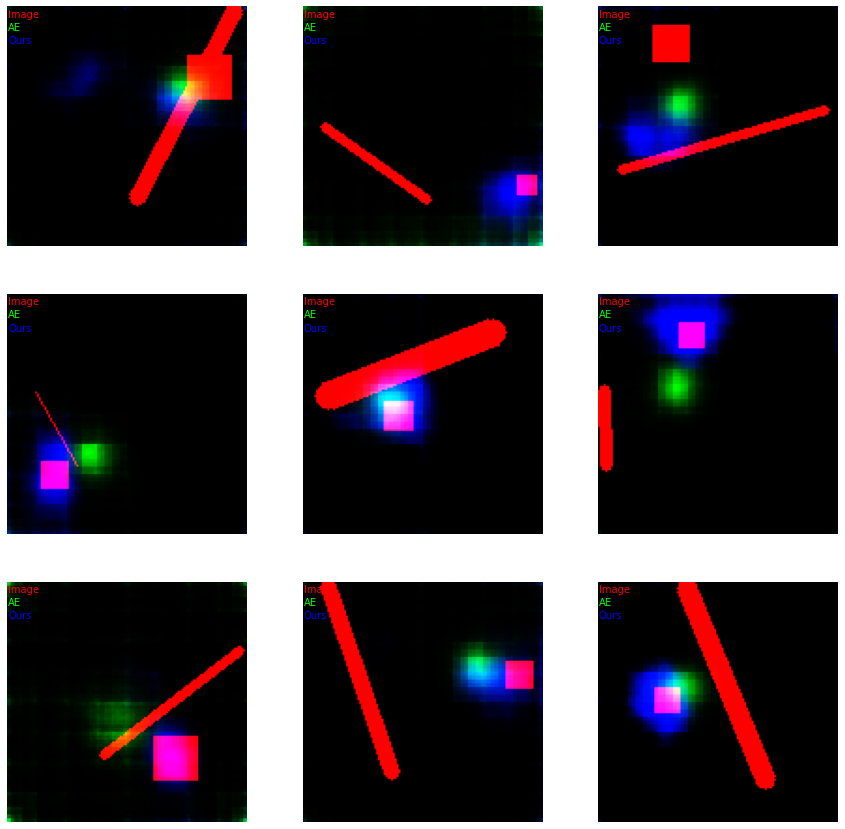

In [133]:
def get_image_with_lines(n: int = 1):
    height, width, channels = 128, 128, 1
    color = (1, 1, 1)
    img = generate_random_square()
    for _ in range(n):
        # Add random circle 
        start = (np.random.randint(height), np.random.randint(width))
        end = (np.random.randint(height), np.random.randint(width))
        thickness = np.random.randint(1, 20)
        cv.line(img, start, end, color, thickness)
    return img


fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        image = get_image_with_lines()
        tensor = torch.from_numpy(image).permute(2, 0, 1).float().unsqueeze(0)
        reconstruction_ae = autoencoder(tensor).cpu().detach().squeeze().numpy()
        reconstruction_triplet = decoder(encoder(tensor)).cpu().detach().squeeze().numpy()

        stacked = np.stack([image.squeeze(), normalize(reconstruction_ae.squeeze()), normalize(reconstruction_triplet.squeeze())], axis=-1)
        axes[i, j].imshow(stacked)
        axes[i, j].text(0, 5, 'Image', color=(1, 0, 0))
        axes[i, j].text(0, 12, 'AE', color=(0, 1, 0))
        axes[i, j].text(0, 19, 'Ours', color=(0, 0, 1))
        axes[i, j].axis('off')
plt.show()